In [1]:
FEATURE_SELECTION = True
SCRIPT_TESTING = False

import pandas as pd
import numpy as np #==1.23.4 compatible with lightgbm and bayessearchcv
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

import time
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from utils import modeling_utils as mu

In [2]:
df = pd.read_csv('../data/german_credit_data.csv')

df = df.drop(['Unnamed: 0'], axis=1)
df.columns = [x.lower().replace(' ', '_') for x in df.columns]

In [3]:
numerical_features = ['age', 'credit_amount', 'duration']
categorical_features = ['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose']

job_dic = {
    0: 'unskilled non res',
    1: 'unskilled resident',
    2: 'skilled',
    3: 'highly skilled'
}
df.job = df.job.map(job_dic)

In [4]:
df.saving_accounts = df.saving_accounts.fillna('undefined')
df.checking_account = df.checking_account.fillna('undefined') ## we are treating indefinitions are new categories as they have strong relations with target

df['target'] = (df.risk == 'bad').astype(int)
df.isna().sum().sum()

0

In [5]:
df.sample(3)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk,target
542,31,male,skilled,own,undefined,little,6350,30,furniture/equipment,bad,1
582,26,female,skilled,rent,little,undefined,1388,9,furniture/equipment,good,0
990,37,male,unskilled resident,own,undefined,undefined,3565,12,education,good,0


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['risk', 'target'], axis=1), df.target, 
                                                    test_size=0.2, random_state=42, stratify = df.target)

if SCRIPT_TESTING:
    X_train = X_train.head(80)
    y_train = y_train.head(80)

## Model pipeline definition

The transformer below will apply the feature creations and transformations explained on the preprocessing notebook
- It is important that it is put in a Pipeline because it's a transformation that would cause a lot of data leakage if done on the entire dataset

In [7]:
class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,  numerical_features, categorical_features, dropped_features = []):
        self.dropped_features = dropped_features
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        pass
    
    def fit(self, X, y=None):
        self.categorical_features_order = mu.sort_categorical_values_by_correlation(
            X.copy(), y, self.categorical_features)
        self.positive_and_negative_indicators_frme = mu.find_positive_and_negative_indicators(
            X.copy(), y, self.numerical_features, self.categorical_features)
        return self

    def transform(self, X):
        X = mu.encode_categorical_values(X.copy(), self.categorical_features_order)
        X = mu.apply_indicators_conditions(X.copy(), self.positive_and_negative_indicators_frme)
        X = X.drop(self.dropped_features, axis = 1)
        self.features = X.columns
        return X


In [8]:
### receives a model and a parameter range and uses bayes search to find the best parameters and scores
def model_testing_pipeline(model, model_params, cv, n_iter, print_scores=True, dropped_features = []):

    pipeline = Pipeline([
        ('preprocess', PreprocessingTransformer(numerical_features, categorical_features, dropped_features)), 
        ('model', model)])

    bayes_search = BayesSearchCV(
        pipeline,
        model_params,
        cv=cv,
        verbose=-1,
        n_jobs=-1,
        return_train_score=True,
        n_iter = n_iter,
        scoring='roc_auc')

    bayes_search.fit(X_train, y_train)

    best_estimator_test_score = bayes_search.best_score_
    best_estimator_train_score = bayes_search.cv_results_['mean_train_score'][bayes_search.best_index_]

    output = {
        'best_estimator_test_score': best_estimator_test_score,
        'best_estimator_train_score': best_estimator_train_score,
        'best_estimator_test_score_std': bayes_search.cv_results_['std_test_score'][bayes_search.best_index_],
        'best_estimator': bayes_search.best_estimator_,
        'best_params': bayes_search.best_params_}
        
    mu.warn(model_params, bayes_search.best_params_)

    if print_scores == True:
        print('best estimator test score:', best_estimator_test_score)
        print('best estimator train score:', best_estimator_train_score)

    return output, bayes_search


## Model selection

In [9]:
cv, n_iter = 5, 50

#### lgbm (gradient boosting)

In [10]:
model = lgb.LGBMClassifier(verbose = -1)

model_params = {
    'model__num_leaves': Integer(2, 100, 'uniform'),
    'model__feature_fraction': Real(0.1, 1, 'uniform'),
    'model__learning_rate': Real(0.001, 0.1, 'log-uniform'),
    'model__boosting_type': Categorical(['gbdt', 'dart', 'goss']),
    'model__n_estimators': Integer(30, 300, 'uniform'),
}

boosting_test_results, _ = model_testing_pipeline(model, model_params, cv, n_iter)

best estimator test score: 0.7533668154761904
best estimator train score: 0.7783017113095239


#### lgbm (random forest)

In [11]:
model = lgb.LGBMClassifier(verbose = -1, boosting_type ='rf', 
                            bagging_freq = 1, bagging_fraction =0.6, n_estimators=200)

model_params = {
    'model__num_leaves': Integer(2, 100, 'uniform'),
    'model__feature_fraction': Real(0.1, 1, 'uniform'),
    'model__min_child_samples': Integer(5, 200, 'uniform'),
}

bagging_test_results, _ = model_testing_pipeline(model, model_params, cv, n_iter)

best estimator test score: 0.7562872023809524
best estimator train score: 0.9194405691964285


- The model choice is boosting lgbm

In [12]:
best_params = boosting_test_results['best_params']
best_params

OrderedDict([('model__boosting_type', 'goss'),
             ('model__feature_fraction', 0.5068016716408755),
             ('model__learning_rate', 0.014266525121006651),
             ('model__n_estimators', 177),
             ('model__num_leaves', 2)])

## Feature selection

Feature selection will be done by backward elimination. The model starts with every feature

Then each elimination round can be described as:

- The performance of every feature is tested by removing it from the model and training/testing the model

- The training/testing happens multiple times per removed feature, and the result is averaged

- The feature with the worst result (as measured by test roc-auc) is dropped

- The test will be direct, meaning lower roc-auc loses with no hypothesis test, for simplicity

- The proccess stops when in a round no feature is found to worsen the model

In [13]:
def backward_elimination_round(n_evaluations, model, model_params, all_features, previously_removed):
    rows = []

    all_tested_feats = [x for x in all_features if x not in previously_removed]

    for i in range(n_evaluations):
        for tested_feature in (all_tested_feats + [[]])[::-1]:
            feature_formatted = tested_feature if type(tested_feature) == list else [tested_feature]
            dropped = list(set(feature_formatted).union(set(previously_removed)))
            
            pipeline = Pipeline([
                ('preprocess', PreprocessingTransformer(numerical_features, categorical_features, dropped)), 
                ('model', model)])
            xtrain, xtest, ytrain, ytest = train_test_split(
                X_train, y_train, test_size=0.2, stratify = y_train)
            pipeline.fit(xtrain, ytrain)
            ypred = pipeline.predict_proba(xtest)[:,1]
            auc = roc_auc_score(ytest, ypred)

            res = (pd.DataFrame({
                    'removed_feature': str(tested_feature),
                    'test_score': auc}, index=[0])
                    )

            rows.append(res)

    results = pd.concat(rows).reset_index(drop=True)

    results.removed_feature = results.removed_feature.astype(str)
    results ['avg_test_score'] = results.groupby('removed_feature').test_score.transform('mean')
    results = results.sort_values('avg_test_score', ascending=False).drop_duplicates('removed_feature').reset_index(drop=True)
    results = results.drop('test_score', axis=1)

    worse = results.iloc[0]
    worse_feature = worse.removed_feature

    if worse_feature == '[]':
        print('Finished.')
        return '[]', results
    else:
        print('Removing', worse_feature)
        return worse_feature, results

In [14]:
all_features = numerical_features + categorical_features + [
    'positive_negative_balance', 'number_positive_indicators', 'number_negative_indicators']

In [17]:
n_evaluations_per_round = 20

model = lgb.LGBMClassifier(**best_params, verbose = -1)

previously_removed = []
removed = ''

if FEATURE_SELECTION == False:
    removed = '[]' ## it's going to skip the while below

result = pd.DataFrame()
while removed != '[]':
    start = time.time()
    removed, round_res = backward_elimination_round(n_evaluations_per_round, model, model_params,
                        all_features[::-1], previously_removed = previously_removed)
    previously_removed.append(removed)
    round_res['round'] = len(previously_removed)
    round_res['round_removed'] = removed
    result = pd.concat([result, round_res])
    display(round_res)
    print('Round duration:', round(time.time() - start, 1), 'seconds. Removed feature:', removed, '\n')

Removing number_negative_indicators


,removed_feature,avg_test_score,round,round_removed
0,number_negative_indicators,0.733687,1,number_negative_indicators
1,purpose,0.725270,1,number_negative_indicators
2,[],0.723168,1,number_negative_indicators
3,housing,0.721987,1,number_negative_indicators
4,positive_negative_balance,0.718573,1,number_negative_indicators
5,job,0.715978,1,number_negative_indicators
6,age,0.715839,1,number_negative_indicators
7,number_positive_indicators,0.714714,1,number_negative_indicators
8,sex,0.714481,1,number_negative_indicators
9,saving_accounts,0.709645,1,number_negative_indicators


Round duration: 68.7 seconds. Removed feature: number_negative_indicators 

Removing housing


,removed_feature,avg_test_score,round,round_removed
0,housing,0.748717,2,housing
1,[],0.740355,2,housing
2,age,0.736798,2,housing
3,job,0.729818,2,housing
4,saving_accounts,0.727604,2,housing
5,positive_negative_balance,0.727455,2,housing
6,purpose,0.725344,2,housing
7,number_positive_indicators,0.720982,2,housing
8,duration,0.719448,2,housing
9,sex,0.714416,2,housing


Round duration: 62.2 seconds. Removed feature: housing 

Removing job


,removed_feature,avg_test_score,round,round_removed
0,job,0.741499,3,job
1,number_positive_indicators,0.735510,3,job
2,purpose,0.734854,3,job
3,sex,0.734208,3,job
4,age,0.732096,3,job
5,saving_accounts,0.727781,3,job
6,[],0.724023,3,job
7,duration,0.720875,3,job
8,positive_negative_balance,0.716016,3,job
9,credit_amount,0.707492,3,job


Round duration: 56.3 seconds. Removed feature: job 

Finished.


,removed_feature,avg_test_score,round,round_removed
0,[],0.735631,4,[]
1,saving_accounts,0.735361,4,[]
2,age,0.731915,4,[]
3,purpose,0.726497,4,[]
4,sex,0.726488,4,[]
5,positive_negative_balance,0.724284,4,[]
6,number_positive_indicators,0.724163,4,[]
7,credit_amount,0.713704,4,[]
8,duration,0.703037,4,[]
9,checking_account,0.654511,4,[]


Round duration: 51.4 seconds. Removed feature: [] 



In [18]:
selected_out = previously_removed
selected_out.remove('[]')
selected_out

['number_negative_indicators', 'housing', 'job']

## Final tuning and result

In [20]:
model = lgb.LGBMClassifier(verbose = -1, 
                            boosting_type = best_params['model__boosting_type'],
                            learning_rate = None, num_leaves = None, n_estimators = None, feature_fraction = None)

model_params = {
    'model__learning_rate': Real(0.001, 0.1, 'log-uniform'),
    'model__num_leaves': Integer(2, 50, 'uniform'),
    'model__n_estimators': Integer(30, 300, 'uniform'),
    'model__feature_fraction': Real(0.01, 1, 'uniform')
    }

final_model_test_results, best_model = model_testing_pipeline(
    model, model_params, cv = 5, n_iter = 100, dropped_features=selected_out)

best estimator test score: 0.76640625
best estimator train score: 0.8759835379464287


In [21]:
final_model_test_results['best_params']

OrderedDict([('model__feature_fraction', 0.37471599816468937),
             ('model__learning_rate', 0.014876086312025343),
             ('model__n_estimators', 300),
             ('model__num_leaves', 50)])

In [22]:
y_pred_proba = best_model.predict_proba(X_test)[:,1]

test_set_results = pd.DataFrame()
test_set_results['y_test'] = y_test
test_set_results['y_pred_proba'] = y_pred_proba
test_set_results.to_csv('../data/test_set_results.csv', index=False)

auc score: 0.7658333333333333


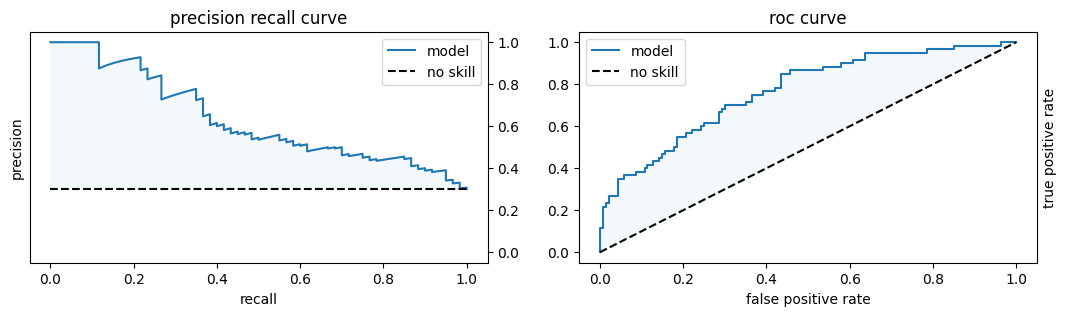

In [23]:
## test be
# st_model on the test set

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

print('auc score:', roc_auc_score(y_test, y_pred_proba))

## precision recall curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

class_imbalance = y_test.value_counts(normalize=True)[1]

_, ax = plt.subplots(1, 2, figsize=(13, 3))
ax[0].plot(recall, precision, label = 'model')
ax[0].plot([0, 1], [class_imbalance, class_imbalance], 'k--', label = 'no skill')
ax[0].fill_between(recall, precision, 0, alpha=0.05)
ax[0].fill_between([0, 1], [class_imbalance, class_imbalance], color = 'white')
ax[0].set_xlabel('recall')
ax[0].set_ylabel('precision')
ax[0].set_title('precision recall curve')
ax[0].yaxis.tick_right()
ax[0].set_ylim([-0.05, 1.05])
ax[0].legend()

ax[1].plot(fpr, tpr, label = 'model')
ax[1].plot([0, 1], [0, 1], 'k--', label = 'no skill')
ax[1].fill_between(fpr, tpr, 0, alpha=0.05)
ax[1].fill_between([0, 1], [0, 1], color = 'white')
ax[1].legend()


ax[1].set_xlabel('false positive rate')
ax[1].set_ylabel('true positive rate')
ax[1].set_title('roc curve')
ax[1].yaxis.set_label_position("right")
## print auc score

## Classification threshold selection

Let's select the threshold based on how it can affect the company's bottom line. We estimate this by considering the number of correctly identified bad customers as positive returns and the number of lost, misclassified good customers.

The outcome depends on the relative cost of acquiring a bad customer versus a good one. Since we lack information about the German Bank, I'll highlight two scenarios:

1. If the loss from acquiring a bad customer equals the gain from acquiring a good one

2. If acquiring a bad customer is five times more expensive than acquiring a good one

In [24]:
n_good_clients = (y_test == 0).sum()
n_bad_clients = (y_test == 1).sum()

res = pd.DataFrame()
for threshold in np.linspace(0.0, 1.0, 11).tolist():
    pred = (y_pred_proba >= threshold).astype(int)
    tp = ((pred == 1) & (y_test == 1)).sum()
    tn = ((pred == 0) & (y_test == 0)).sum()
    fp = ((pred == 1) & (y_test == 0)).sum()

    precision = tp / (tp + fp)
    specificity = tn / n_good_clients
    sensitivity = tp / n_bad_clients

    row = pd.DataFrame({ 
        'thres': threshold, 'precision': 100*precision, 'recall/sensitivity': 100*sensitivity,
        'specificity': 100*specificity, 'lost_good_clients': fp, 'avoided_bad_clients': tp
        }, index=[0])

    res = pd.concat([res, row]).reset_index(drop=True)
    if sensitivity == 0: break
res = res.round(2)

### Scenario 1

In [25]:
res['expected_return'] = res['avoided_bad_clients'] - res['lost_good_clients']
res['bottom_line'] = n_good_clients - res.lost_good_clients - (n_bad_clients - res.avoided_bad_clients)
display(res)
print('Total number of GOOD clients in the test set:', n_good_clients)
print('Total number of BAD clients in the test set: ', n_bad_clients)

,thres,precision,recall/sensitivity,specificity,lost_good_clients,avoided_bad_clients,expected_return,bottom_line
0,0.0,30.00,100.00,0.00,140,60,-80,0
1,0.1,32.96,98.33,14.29,120,59,-61,19
2,0.2,40.00,90.00,42.14,81,54,-27,53
3,0.3,46.24,71.67,64.29,50,43,-7,73
4,0.4,53.03,58.33,77.86,31,35,4,84
5,0.5,62.16,38.33,90.00,14,23,9,89
6,0.6,82.35,23.33,97.86,3,14,11,91
7,0.7,100.00,10.00,100.00,0,6,6,86
8,0.8,NaN,0.00,100.00,0,0,0,80


Total number of GOOD clients in the test set: 140
Total number of BAD clients in the test set:  60


We can observe the following:

- The last row illustrates the company's default scenario without any model. In this situation, the company's bottom line stands at 80, where 1 represents the expected net return of a good customer.

- On the other extreme, the first row represents the case where every customer is prevented. In this scenario, the model's expected return is to prevent all returns, resulting in a bottom line of zero.

- By setting a threshold of 0.6, we avoid 18 bad customers but lose 7 good ones, leading to an expected return of 11. This represents an 11% increase in the company's bottom line compared to not using any model.

### Scenario 2

In [26]:
bad_client_cost = 5

res_ = res.drop('bottom_line', axis = 1)
res_['loss'] = res_.lost_good_clients 
res_['gain'] = res_.avoided_bad_clients*bad_client_cost
res_['expected_return'] = res_.gain - res_.loss

res_['bottom_line'] = (n_good_clients - res_.lost_good_clients 
                                - bad_client_cost*(n_bad_clients - res_.avoided_bad_clients))
res_

,thres,precision,recall/sensitivity,specificity,lost_good_clients,avoided_bad_clients,expected_return,loss,gain,bottom_line
0,0.0,30.00,100.00,0.00,140,60,160,140,300,0
1,0.1,32.96,98.33,14.29,120,59,175,120,295,15
2,0.2,40.00,90.00,42.14,81,54,189,81,270,29
3,0.3,46.24,71.67,64.29,50,43,165,50,215,5
4,0.4,53.03,58.33,77.86,31,35,144,31,175,-16
5,0.5,62.16,38.33,90.00,14,23,101,14,115,-59
6,0.6,82.35,23.33,97.86,3,14,67,3,70,-93
7,0.7,100.00,10.00,100.00,0,6,30,0,30,-130
8,0.8,NaN,0.00,100.00,0,0,0,0,0,-160


In this extreme scenario, where bad customers are significantly more costly:

- Not using any model results in a negative bottom line due to 140 good customers and 60 bad customers, each five times as costly as a good one.

- The optimal threshold choice is now 0.2, much lower than in the previous case.

- Achieving higher recall is crucial given the high cost of bad customers.

- Selecting the previous threshold would still benefit the company compared to no model but is far from optimal.

- The company's profitability hinges on the model and the threshold choice in this context.

### Notes
There are some relevant assumptions to the calculation above. Most relevantly:
- It assumes that the bad to good customer ratio of 0.3 represents the customers's real customer base well. The threshold choice is sensible to this variable and this should be taken into account when selecting it

- There's a hidden assumption that the expected return of good customers that get misclassified by the model is the same as that of general good customers. But the model can be biased to misclassifying specific groups of customers. The above calculation could still be done in this case but this has to be accounted for